## 0.Imports

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import requests
import json
from dbrepo.RestClient import RestClient
warnings.filterwarnings("ignore")

# # Load your dataset
username = os.getenv("DBREPO_USER")
password = os.getenv("DBREPO_PASSWORD")
client = RestClient(endpoint="https://test.dbrepo.tuwien.ac.at", username=username, password=password)

models = {}
model_accuracies = {}
model_precisions = {}
model_recalls = {}
model_f1_score = {}

In [5]:
df = client.get_identifier_data(identifier_id="14ccb3a6-328a-48be-9d6e-392040065074")

#drop id
df = df.drop(columns=['id'])

#convert all columns except 'fail' to numeric
cols_to_convert = df.columns.difference(['fail'])
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

## 1.Data exploration

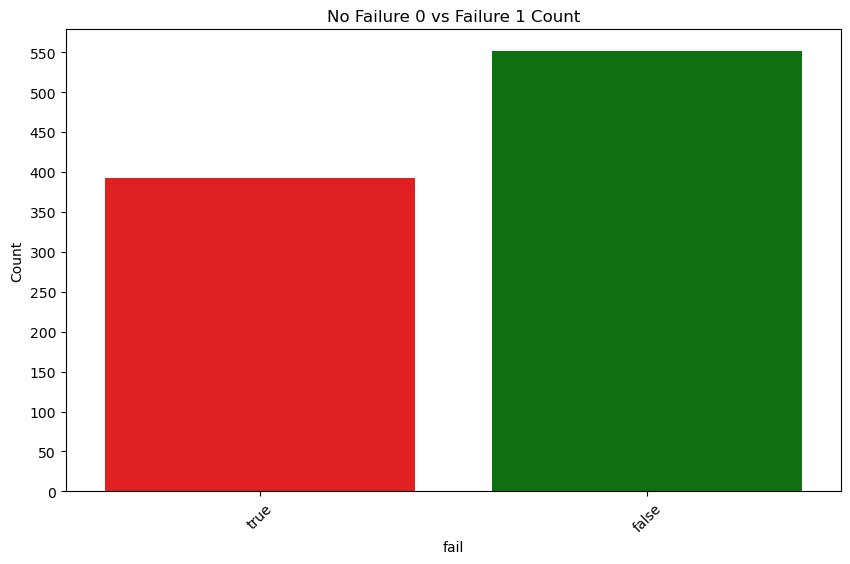

NaN counts in each column:
footfall       0
tempmode       0
aq             0
uss            0
cs             0
voc            0
rp             0
ip             0
temperature    0
fail           0
dtype: int64
Any NaN values in the dataframe: False

Number of columns in the dataset:
10

Number of rows in the dataset:
944


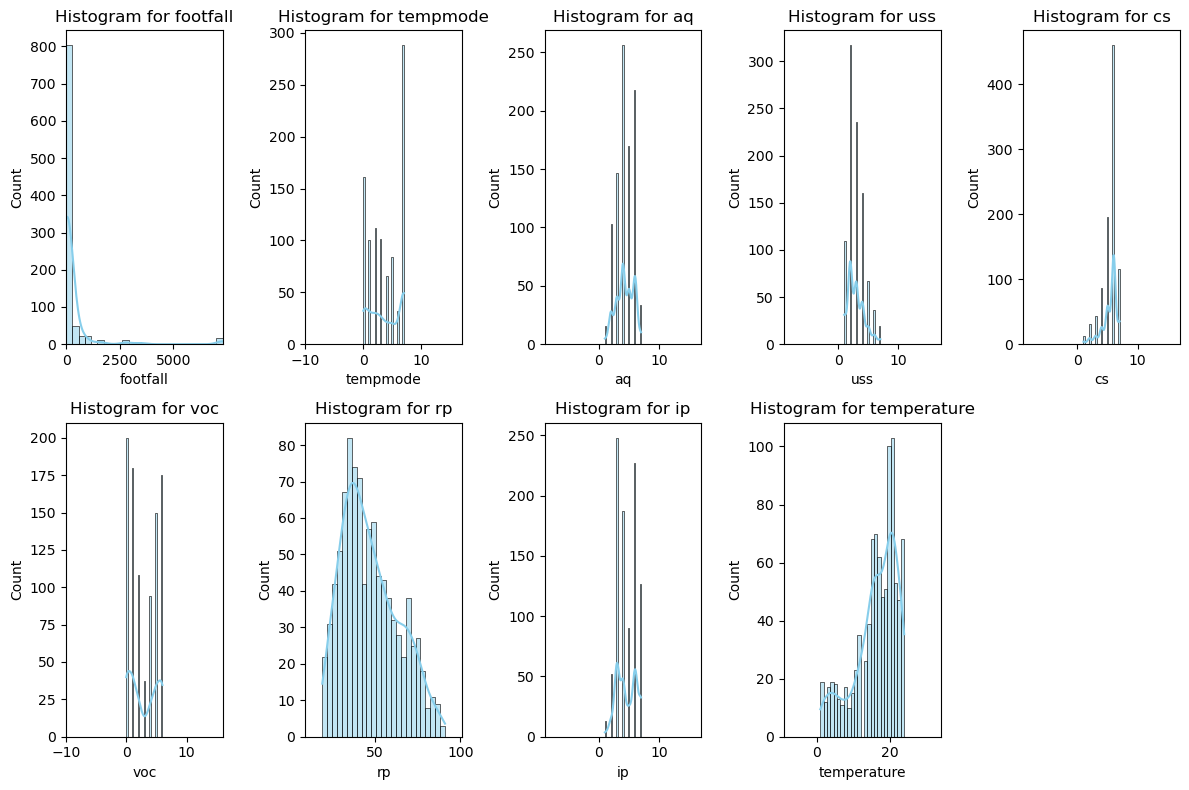

,footfall,tempmode,aq,uss,cs,voc,rp,ip,temperature
count,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000
mean,306.381356,3.727754,4.325212,2.939619,5.394068,2.842161,47.043432,4.565678,16.331568
std,1082.606745,2.677235,1.438436,1.383725,1.269349,2.273337,16.423130,1.599287,5.974781
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,19.000000,1.000000,1.000000
25%,1.000000,1.000000,3.000000,2.000000,5.000000,1.000000,34.000000,3.000000,14.000000
50%,22.000000,3.000000,4.000000,3.000000,6.000000,2.000000,44.000000,4.000000,17.000000
75%,110.000000,7.000000,6.000000,4.000000,6.000000,5.000000,58.000000,6.000000,21.000000
max,7300.000000,7.000000,7.000000,7.000000,7.000000,6.000000,91.000000,7.000000,24.000000


In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='fail',palette={'red','green'}, hue='fail')

# Adding labels and title
plt.title("No Failure 0 vs Failure 1 Count")
plt.xlabel("fail")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.yticks(np.arange(0, df['fail'].value_counts().max() + 1, step=50))  # Adjust step as needed for more tick marks

plt.show()

nan_summary = df.isna().sum()

print("NaN counts in each column:")
print(nan_summary)

print("Any NaN values in the dataframe:", df.isna().any().any())

print("\nNumber of columns in the dataset:")
print(df.shape[1])
print("\nNumber of rows in the dataset:")
print(df.shape[0])

plt.figure(figsize=(12, 8))

# Loop through each column and create a histogram for each
for i, column in enumerate(df.drop(columns=['fail']).columns, 1):
    plt.subplot(2, 5, i)  # Adjust subplot dimensions based on the number of columns
    sns.histplot(df[column], kde=True, color='skyblue', bins=25)
    plt.title(f"Histogram for {column}")
    
    # Adjust x-axis limits to widen the range (you can set the limits according to your data's min and max)
    plt.xlim(df[column].min() - 10, df[column].max() + 10)

plt.tight_layout()
plt.show()

df.describe()


In [8]:
df[df['footfall'] == 7300]


,footfall,tempmode,aq,uss,cs,voc,rp,ip,temperature,fail
115,7300,5,7,7,6,3,21,2,8,false
125,7300,5,3,4,3,3,36,4,8,false
130,7300,1,2,2,7,3,27,6,9,false
161,7300,3,5,3,6,1,19,4,11,false
249,7300,3,2,2,6,0,37,4,14,false
288,7300,7,4,2,4,4,63,6,15,true
399,7300,2,3,3,4,0,62,4,16,false
423,7300,0,4,2,6,3,79,4,17,false
462,7300,1,6,3,6,6,32,3,17,true
515,7300,7,4,4,7,0,44,5,18,false


In [10]:
df[df['footfall'] == 1]


,footfall,tempmode,aq,uss,cs,voc,rp,ip,temperature,fail
91,1,1,4,2,7,2,39,6,6,false
199,1,7,6,2,5,5,73,3,12,true
215,1,0,6,2,4,5,30,5,13,true
300,1,7,5,3,4,5,73,5,15,true
384,1,7,4,7,2,0,53,1,16,false
460,1,3,3,3,5,0,41,3,17,false
468,1,0,6,2,5,2,33,6,17,false
477,1,5,2,3,6,0,27,6,18,false
480,1,5,2,3,6,2,47,7,18,false
560,1,7,1,2,7,1,55,4,19,false


Conclusion: We will not consider the rows with footfall = 7800 outliers. We have tried to drop them an run the models, however they generated a worse f1 socre (dropped from 0.9 to 0.89)

In [13]:
#df = df[df['footfall'] != 7300]

## 2. Data preprocessing


In [19]:
#load training dataset
train_df = client.get_identifier_data(identifier_id="5260f0d5-8d7c-4f11-a209-99d53e70a910")

#convert all columns except 'fail' to numeric
cols_to_convert = train_df.columns.difference(['fail'])
train_df[cols_to_convert] = train_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

#separate features and target
X_train = pd.DataFrame(train_df.drop(columns=["fail"]))
y_train = train_df["fail"]
y_train = y_train.str.lower().map({'false': 0, 'true': 1}).astype(int)

#display number of rows
print("\nNumber of rows in the training dataset:")
print(train_df.shape[0])


#load validation dataset
valid_df = client.get_identifier_data(identifier_id="1cef7e7d-a77b-48b7-b9aa-26bb139fa02e")

#convert all columns except 'fail' to numeric
cols_to_convert = valid_df.columns.difference(['fail'])
valid_df[cols_to_convert] = valid_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

#separate features and target
X_valid = pd.DataFrame(valid_df.drop(columns=["fail"]))
y_valid = valid_df["fail"]
y_valid = y_valid.str.lower().map({'false': 0, 'true': 1}).astype(int)

#display number of rows
print("\nNumber of rows in the validation dataset:")
print(valid_df.shape[0])

#load test dataset
test_df = client.get_identifier_data(identifier_id="f39fc5c8-251b-4c86-9271-a1ba23fd30f1")

#convert all columns except 'fail' to numeric
cols_to_convert = test_df.columns.difference(['fail'])
test_df[cols_to_convert] = test_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

#separate features and target
X_test = pd.DataFrame(test_df.drop(columns=["fail"]))
y_test = test_df["fail"]
y_test = y_test.str.lower().map({'false': 0, 'true': 1}).astype(int)

#display number of rows
print("\nNumber of rows in the test dataset:")
print(test_df.shape[0])


Number of rows in the training dataset:
604

Number of rows in the validation dataset:
151

Number of rows in the test dataset:
189


## 3. Modelling experiments

### 3.0 Function for GridSearch

In [22]:
def perform_grid_search(model, params):
    """
    Performs Grid Search for hyperparameter tuning using train-validation split
    - GridSearchCV is performed on (X_train, y_train) using cross-validation
    - The best model is selected based on validation performance
    - The best model is re-trained on the full train + validation set
    - The final model is evaluated on the test set
    Returns:
        - best_model: The trained model with the best parameters
        - test_accuracy, precision, recall, f1: Performance metrics on the test set
        - conf_matrix: Confusion matrix of the test set predictions
    """

    #set up GridSearchCV with the model and the hyperparameter grid
    grid_search = GridSearchCV(
        estimator=model, param_grid=params, cv=3, verbose=3, 
        n_jobs=-1, scoring='f1'
    )

    #fit GridSearchCV to the training data (only X_train, y_train)
    grid_search.fit(X_train, y_train)
    
    #convert cv_results_ to a DataFrame for easy sorting and filtering
    results = pd.DataFrame(grid_search.cv_results_)

    #sort by mean test score in descending order
    sorted_results = results.sort_values(by='mean_test_score', ascending=False)

    #display the top 5 results
    top_5_results = sorted_results.head(5)
    print(top_5_results[['params', 'mean_test_score', 'std_test_score', 'mean_fit_time']])
    
    #print the best parameters and best score
    print("Best Parameters found by GridSearchCV:")
    print(grid_search.best_params_)
    print("Best Cross-Validation F1 score:", grid_search.best_score_)

    #evaluate the best model on the validation set
    best_model = grid_search.best_estimator_
    y_valid_pred = best_model.predict(X_valid)
    
    #compute metrics on validation set
    valid_f1 = f1_score(y_valid, y_valid_pred, average='binary')  
    print("Validation F1 Score of the best model:", valid_f1)
    
    #re-train best model using Train + Validation before final test evaluation
    X_final_train = pd.concat([X_train, X_valid])
    y_final_train = pd.concat([y_train, y_valid])
    best_model.fit(X_final_train, y_final_train)

    #final evaluation on the test set
    y_test_pred = best_model.predict(X_test)
    
    #calculate accuracy, precision, recall, and f1 score
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='binary')  
    recall = recall_score(y_test, y_test_pred, average='binary')  
    f1 = f1_score(y_test, y_test_pred, average='binary')  

    #print test metrics
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    #create Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    return best_model, grid_search.best_params_ , test_accuracy, precision, recall, f1, conf_matrix


In [23]:
print(X_train.dtypes)
print(X_train.isna().sum())
print(y_train.value_counts(dropna=False))

id             int64
footfall       int64
tempmode       int64
aq             int64
uss            int64
cs             int64
voc            int64
rp             int64
ip             int64
temperature    int64
dtype: object
id             0
footfall       0
tempmode       0
aq             0
uss            0
cs             0
voc            0
rp             0
ip             0
temperature    0
dtype: int64
fail
0    353
1    251
Name: count, dtype: int64


### Saving the Results

In [28]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

def save_results(model_name, best_model, best_params, test_accuracy, precision, recall, f1, conf_matrix):
    """
    Saves model, performance metrics, and confusion matrix to files.
    
    Args:
        model_name: Name of the model
        best_model: The trained model
        best_params: Best hyperparameters found via GridSearch
        test_accuracy: Accuracy on the test set
        precision: Precision score on the test set
        recall: Recall score on the test set
        f1: F1 score on the test set
        conf_matrix (ndarray): Confusion matrix for the test set
    """

    results_dir = "results"
    os.makedirs(results_dir, exist_ok=True)

    # Save performance metrics
    results_path = os.path.join(results_dir, f"best_results_{model_name}.txt")
    with open(results_path, "w") as file:
        file.write(f"Model: {model_name}\n")
        file.write(f"Best Parameters: {best_params}\n")
        file.write("\nTest Set Performance\n")
        file.write(f"Test Accuracy: {test_accuracy:.4f}\n")
        file.write(f"Precision: {precision:.4f}\n")
        file.write(f"Recall: {recall:.4f}\n")
        file.write(f"F1 Score: {f1:.4f}\n")
    print(f"Results saved to {results_path}")

    # Save confusion matrix plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {model_name}")

    confusion_matrix_path = os.path.join(results_dir, f"confusion_matrix_{model_name}.png")
    plt.savefig(confusion_matrix_path)
    plt.close()
    print(f"Confusion matrix saved to {confusion_matrix_path}")

    # Save the trained model
    model_path = os.path.join(results_dir, f"trained_model_{model_name}.pkl")
    joblib.dump(best_model, model_path)
    print(f"Trained model saved to {model_path}")

### 3.1 Logistic Regression

In [31]:
model_lr = LogisticRegression(random_state=42)


lr_params = {
    'penalty': [None,'l1', 'l2'], # regularization Lasso (sets some params to zero, Ridge regularization (penalizes large coefficients but does not set them to zero)
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # lambda for regularization strength (small - stronger Regularization, large - weaker regularization
    'solver': ['liblinear', 'saga'], # solvers that support both L1 and L2, saga is good for large datasets, liblinear for smaller ones
    'max_iter': [100, 200, 500, 1000] # iterations allowed for convergence, it either converges or stops after the reached nr of iterations
}


best_model_lr, best_params_lr, test_accuracy_lr, test_precision_lr, test_recall_lr, test_f1_lr, confusion_matrix_lr = perform_grid_search(model_lr, lr_params)
models["Logistic Regression"] = best_model_lr
model_accuracies["Logistic Regression"] = test_accuracy_lr
model_precisions["Logistic Regression"] = test_precision_lr
model_recalls["Logistic Regression"] = test_recall_lr
model_f1_score["Logistic Regression"] = test_f1_lr

#save the results, in order for the performance metrics results and confusion matrix to be stored
save_results("LogisticRegression", best_model_lr, best_params_lr, test_accuracy_lr, test_precision_lr, test_recall_lr, test_f1_lr, confusion_matrix_lr)


Fitting 3 folds for each of 144 candidates, totalling 432 fits
                                               params  mean_test_score  \
62  {'C': 0.1, 'max_iter': 500, 'penalty': 'l1', '...         0.840753   
56  {'C': 0.1, 'max_iter': 200, 'penalty': 'l1', '...         0.840753   
68  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', ...         0.840753   
50  {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', '...         0.840753   
52  {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', '...         0.832402   

    std_test_score  mean_fit_time  
62        0.057374       0.010716  
56        0.057374       0.007776  
68        0.057374       0.008007  
50        0.057374       0.008653  
52        0.064243       0.006562  
Best Parameters found by GridSearchCV:
{'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation F1 score: 0.8407531718239337
Validation F1 Score of the best model: 0.8870967741935484
Test Accuracy: 0.9048
Precision: 0.8675
Recall: 0.9114
F1 Sc

### 3.2 KNN

In [33]:
model_knn = KNeighborsClassifier()

knn_params = {
    'n_neighbors': [1, 3, 7, 11, 17, 30], # number of neighbours
    'weights': ['uniform','distance'], # weights of neighbours, unform = all equal, distance = closer ones have more influence
    'metric': ['minkowski', 'euclidean', 'manhattan'] # distance metric euclidean = straight-line distance between two points, manhattan = the distance between two points, calculated by summing the absolute differences of their coordinates, minkowski = a generalization of the previous two
}

best_model_knn, best_params_knn, test_accuracy_knn, test_precision_knn, test_recall_knn, test_f1_knn, confusion_matrix_knn = perform_grid_search(model_knn, knn_params)
models["k-nearest neighbors"] = best_model_knn
model_accuracies["k-nearest neighbors"] = test_accuracy_knn
model_precisions["k-nearest neighbors"] = test_precision_knn
model_recalls["k-nearest neighbors"] = test_recall_knn
model_f1_score["k-nearest neighbors"] = test_f1_knn

save_results("KNN", best_model_knn, best_params_knn, test_accuracy_knn, test_precision_knn, test_recall_knn, test_f1_knn, confusion_matrix_knn)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
                                               params  mean_test_score  \
24  {'metric': 'manhattan', 'n_neighbors': 1, 'wei...         0.305596   
25  {'metric': 'manhattan', 'n_neighbors': 1, 'wei...         0.305596   
27  {'metric': 'manhattan', 'n_neighbors': 3, 'wei...         0.290972   
29  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...         0.288625   
0   {'metric': 'minkowski', 'n_neighbors': 1, 'wei...         0.288275   

    std_test_score  mean_fit_time  
24        0.223362       0.005001  
25        0.223362       0.005009  
27        0.231355       0.005334  
29        0.222759       0.005185  
0         0.236191       0.005919  
Best Parameters found by GridSearchCV:
{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best Cross-Validation F1 score: 0.3055959266265933
Validation F1 Score of the best model: 0.5873015873015873
Test Accuracy: 0.6667
Precision: 0.5952
Recall: 0.6329
F1 Score: 

### 3.3 Random Forest

In [35]:
#define the model
model_rf = RandomForestClassifier(random_state=42)  # Initialize the model (you can add hyperparameters here if needed)

#define the hyperparameter grid to tune
rf_params = {
    'n_estimators': [50, 250, 2000],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3],  # Minimum number of samples required at each leaf node
}

best_model_rf, best_params_rf, test_accuracy_rf, test_precision_rf, test_recall_rf, test_f1_rf, confusion_matrix_rf = perform_grid_search(model_rf, rf_params)
models["Random Forest"] = best_model_rf
model_accuracies["Random Forest"] = test_accuracy_rf
model_precisions["Random Forest"] = test_precision_rf
model_recalls["Random Forest"] = test_recall_rf
model_f1_score["Random Forest"] = test_f1_rf

save_results("RandonmForest", best_model_rf, best_params_rf, test_accuracy_rf, test_precision_rf, test_recall_rf, test_f1_rf, confusion_matrix_rf)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
                                               params  mean_test_score  \
51  {'max_depth': 10, 'min_samples_leaf': 3, 'min_...         0.730979   
78  {'max_depth': 20, 'min_samples_leaf': 3, 'min_...         0.730979   
24  {'max_depth': None, 'min_samples_leaf': 3, 'mi...         0.730979   
3   {'max_depth': None, 'min_samples_leaf': 1, 'mi...         0.586695   
57  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...         0.586695   

    std_test_score  mean_fit_time  
51        0.100374       0.179818  
78        0.100374       0.169529  
24        0.100374       0.172440  
3         0.229137       0.144166  
57        0.229137       0.177351  
Best Parameters found by GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}
Best Cross-Validation F1 score: 0.7309790821601845
Validation F1 Score of the best model: 0.9147286821705426
Test Accuracy: 0.9259
Precision: 0.8916
R

## 4. Result: Select best model

In [37]:
#find the best model based on F1
best_model_name = max(model_f1_score, key=model_f1_score.get)
best_model_f1 = model_f1_score[best_model_name]
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with F1: {best_model_f1:.4f}")

results_path = os.path.join("results", f"winning_model.txt")
with open(results_path, "w") as file:
    file.write(f"\nBest Model: {best_model_name} with F1: {best_model_f1:.4f}")


Best Model: Random Forest with F1: 0.9136


In [38]:
sorted_models = sorted(model_f1_score.items(), key=lambda x: x[1], reverse=True)[:3]
results_path = os.path.join("results", f"models_ranking.txt")
with open(results_path, "w") as file:
    file.write("Ranking based on F1:\n")
    for rank, (model_name, f1_score) in enumerate(sorted_models, start=1):
        print(f"{rank}. {model_name} - F1 Score: {f1_score:.4f}")
        file.write(f"{rank}. {model_name} - F1 Score: {f1_score:.4f}\n")

1. Random Forest - F1 Score: 0.9136
2. Logistic Regression - F1 Score: 0.8889
3. k-nearest neighbors - F1 Score: 0.6135


## 5. Upload Ouputs to TUWRD Test Instance using the API

In [7]:
# Configuration of the API
base_url = "https://test.researchdata.tuwien.ac.at/api/records"
curation_url = "https://test.researchdata.tuwien.ac.at/api/curations/"
access_token = os.getenv("ACCESS_TOKEN")
folder_path = "results/"  # Path to your "results" folder

headers = {
    "Authorization": f"Bearer {access_token}",
    "Content-Type": "application/json",
}

# Create a new draft record ---
print("Creating a new draft record...")
data = {
    "metadata": {
        "resource_type": {"id": "model"},
        "title": "Hyperparameter Optimization and Model Selection - Trained Model and Performance Results",  # You can update this later
    },
    "files": {"enabled": True},
}

response = requests.post(base_url, headers=headers, json=data)
try:
    response.raise_for_status()  # Raise an exception for bad status codes
    record_data = response.json()
    record_id = record_data["id"]
    files_url = f"{base_url}/{record_id}/draft/files"
    print(f"Draft record created successfully. Record ID: {record_id}")

    # Initialize file uploads ---
    filenames = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if filenames:
        print("\nInitializing file uploads...")
        files_to_upload = [{"key": f} for f in filenames]
        response = requests.post(files_url, headers=headers, json=files_to_upload)
        response.raise_for_status()
        files_data = response.json()
        print("File uploads initialized.")
        print(f"Files data response: {files_data}")

        # Upload file content ---
        print("\nUploading file contents...")
        for file_info in files_data["entries"]:  # Iterate through the 'entries' list
            filename = file_info["key"]
            upload_url = file_info["links"]["content"]
            file_path = os.path.join(folder_path, filename)
            print(f"Uploading: {filename}")
            upload_headers = {"Authorization": f"Bearer {access_token}", "Content-Type": "application/octet-stream"}
            with open(file_path, "rb") as f:
                response = requests.put(upload_url, headers=upload_headers, data=f)
                response.raise_for_status()
            print(f"  '{filename}' content uploaded.")

            # Commit draft file upload ---
            commit_url = file_info["links"]["commit"]
            response = requests.post(commit_url, headers=headers)
            response.raise_for_status()
            print(f"  '{filename}' committed.")

        print("\nAll files uploaded and committed.")

        # Request a DOI ---
        print("\nRequesting a DOI...")
        doi_url = f"{base_url}/{record_id}/draft/pids/doi"
        response = requests.post(doi_url, headers=headers)
        response.raise_for_status()
        doi_data = response.json()
        print(f"DOI requested. Details: {doi_data}")

        print("\nThe files have been uploaded, a DOI has been requested")
except requests.exceptions.HTTPError as e:
    print(f"An HTTP error occurred: {e}")
    if e.response is not None:
        print(f"Response content: {e.response.text}")

Creating a new draft record...
Draft record created successfully. Record ID: j3pt9-shg53

Initializing file uploads...
File uploads initialized.
Files data response: {'enabled': True, 'links': {'self': 'https://test.researchdata.tuwien.ac.at/api/records/j3pt9-shg53/draft/files'}, 'entries': [{'key': 'best_results_KNN.txt', 'created': '2025-04-23T13:14:22.171805+00:00', 'updated': '2025-04-23T13:14:22.172877+00:00', 'status': 'pending', 'metadata': None, 'access': {'hidden': False}, 'links': {'self': 'https://test.researchdata.tuwien.ac.at/api/records/j3pt9-shg53/draft/files/best_results_KNN.txt', 'content': 'https://test.researchdata.tuwien.ac.at/api/records/j3pt9-shg53/draft/files/best_results_KNN.txt/content', 'commit': 'https://test.researchdata.tuwien.ac.at/api/records/j3pt9-shg53/draft/files/best_results_KNN.txt/commit'}}, {'key': 'best_results_LogisticRegression.txt', 'created': '2025-04-23T13:14:22.174657+00:00', 'updated': '2025-04-23T13:14:22.175628+00:00', 'status': 'pending'